In [2]:
!pip install stable-baselines3[extra]
!pip install stable-baselines3
!pip install gymnasium shimmy
#!pip install torch torchvision torchaudio
!pip install gym_super_mario_bros==7.3.0 nes_py


Defaulting to user installation because normal site-packages is not writeable
  Using cached tzdata-2025.1-py2.py3-none-any.whl.metadata (1.4 kB)
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.4 MB ? eta -:--:--
   --------------- ------------------------ 0.5/1.4 MB 2.8 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 2.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/958.1 kB ? eta -:--:--
   --------------------- ------------------ 524.3/958.1 kB 3.4 MB/s eta 0:00:01
   ---------------------------------------- 958.1/958.1 kB 3.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/10.8 MB ? eta -:--:--
   -- ------------------------------------- 0.8/10.8 MB 4.8 MB/s eta 0:00:03
   ----- ---------------------------------- 1.6/10.8 MB 4.0 MB/s eta 0:00:03
   -------- ------------------------------- 2.4/10.8 MB 4.1 MB/s eta 0:00:03
   ------------ ----------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/721.7 kB ? eta -:--:--
     -------------- ------------------------- 262.1/721.7 kB ? eta -:--:--
     -------------------------------------- 721.7/721.7 kB 2.7 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   --------------------------- ------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [3]:
import torch
import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

In [4]:
env = gym_super_mario_bros.make('SuperMarioBros-v3',apply_api_compatibility=True,render_mode="human")
env = JoypadSpace(env, SIMPLE_MOVEMENT)

C:\Users\guill\anaconda3\envs\ML_practice\Lib\site-packages\gym\envs\registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(


In [4]:
#step_result = env.step(env.action_space.sample())
#
#    if len(step_result) == 4:
#        # Old gym version (returns state, reward, done, info)
##        state, reward, done, info = step_result
#    else:
#        # New gym version (returns state, reward, terminated, truncated, info)
##        state, reward, terminated, truncated, info = step_result
#        done = terminated or truncated  # Merge termination flags

# Preprocessing

In [1]:
import torch
import gym
import gym_super_mario_bros
from gym import RewardWrapper
from gym_super_mario_bros import make

from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
import cv2
import numpy as np  # ✅ Ensure NumPy is imported
import matplotlib.pyplot as plt

from gym.wrappers import FrameStack, GrayScaleObservation, ResizeObservation

from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv

from matplotlib import pyplot as plt 

In [2]:
class NoSeedResetWrapper(gym.Wrapper):
    def reset(self, **kwargs):
        kwargs.pop("seed", None)     # ✅ Remove 'seed' argument
        kwargs.pop("options", None)  # ✅ Remove 'options' argument
        return self.env.reset(**kwargs)


In [3]:
class CustomRewardWrapper(RewardWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.previous_x = 0  # Guardar la posición anterior de Mario
        self.stuck_counter = 0  # Contador para detectar si está atascado

    def step(self, action):
        """
        Llama al método `step()` del entorno y modifica la recompensa antes de retornarla.
        """
        observation, reward, done, truncated, info = self.env.step(action)  

        current_x = info['x_pos']  

        # 🔹 Penalización por paso del tiempo (manteniendo el incentivo para moverse rápido)
        time_penalty = -0.05  

        # 🔹 Recompensa por avanzar (aumentada para priorizar moverse a la derecha)
        progress_reward = (current_x - self.previous_x) * 0.3  

        # 🔹 Bonificación adicional por mantener una velocidad alta
        if (current_x - self.previous_x) > 3:  
            progress_reward += 0.2  

        # 🔹 Penalización si se queda atascado (no se mueve por 10 frames seguidos)
        if current_x == self.previous_x:
            self.stuck_counter += 1
            if self.stuck_counter > 10:  # Penalizar fuerte si se queda en el mismo lugar
                progress_reward -= 10  
        else:
            self.stuck_counter = 0  # Resetear si se mueve

        self.previous_x = current_x  

        # 🔹 Penalización extrema por morir (Aumentada a -500)
        if info['life'] == 0:
            progress_reward -= 500  

        # 🔹 Modificar la recompensa final
        modified_reward = reward + progress_reward + time_penalty
        
        return observation, modified_reward, done, truncated, info  


In [4]:
#create base env 
env = gym_super_mario_bros.make('SuperMarioBros-v0',apply_api_compatibility=True,render_mode="human")

env = JoypadSpace(env, SIMPLE_MOVEMENT)

#actualice the reward system 
#env = CustomRewardWrapper(env)  # Aplicar el wrapper de recompensa

#RESIZES THE SHAPE FOR IT TO CONSUME LESS ENERGY
#env = ResizeObservation(env, shape=84)

#gray scale the env
env = GrayScaleObservation(env, keep_dim=True)
env = NoSeedResetWrapper(env)
#wrap inside dummyy
env = DummyVecEnv([lambda: env])
#stack

env = VecFrameStack(env, 4, channels_order='last')

C:\Users\santi\AppData\Roaming\Python\Python38\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
C:\Users\santi\AppData\Roaming\Python\Python38\site-packages\gym\envs\registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(
C:\Users\santi\AppData\Roaming\Python\Python38\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [5]:
#state = env.reset()
#state.shape
# viene en tuplet la informacion del env.reset  entonces algunas cosas no va a imprimir bien
#state, _ = env.reset()  # Extract only the state
#print(f"State Shape: {state.shape}")
# Reset the environment
state = env.reset()

print(f"State Type: {type(state)}")
print(f"State Shape: {getattr(state, 'shape', 'No Shape Attribute')}")
print(f"State Min: {state.min()}, State Max: {state.max()}")


# If using Gymnasium, state is a tuple (state, info), so extract the state
if isinstance(state, tuple):
    state = state[0]  # Extract the actual observation

# Print the shape of the stacked frames
print(f"State Shape: {state.shape}")


State Type: <class 'numpy.ndarray'>
State Shape: (1, 240, 256, 4)
State Min: 0, State Max: 252
State Shape: (1, 240, 256, 4)


In [6]:
step_result = env.step(env.action_space.sample())

#    if len(step_result) == 4:
#        # Old gym version (returns state, reward, done, info)
#        state, reward, done, info = step_result
#    else:
#        # New gym version (returns state, reward, terminated, truncated, info)
#        state, reward, terminated, truncated, info = step_result
#        done = terminated or truncated  # Merge termination flags

IndentationError: unexpected indent (2124261313.py, line 3)

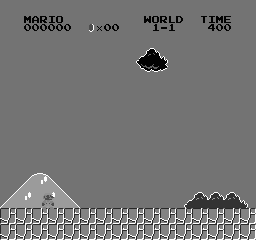

In [7]:
#con esto puedo ver los venditos frames
from PIL import Image
import numpy as np

# Convert to NumPy array
frame = np.array(state[0], dtype=np.uint8)

# Display using PIL
Image.fromarray(frame)


In [10]:
from PIL import Image
import numpy as np

# Get the shape of the stacked state
num_frames = 4  # We stacked 4 frames
frame_height, frame_width = state[0].shape[:2]

# Split the stacked grayscale frames into 4 separate images
frames = np.split(state[0], num_frames, axis=-1)

# Convert each frame to a valid grayscale image (remove last dimension)
frames = [np.squeeze(f, axis=-1) for f in frames]  # Remove extra channel

# Display all frames side by side
combined_frame = np.hstack(frames)  # Combine horizontally
Image.fromarray(combined_frame).show()  # Show the image
for i, frame in enumerate(frames):
    Image.fromarray(frame).show(title=f"Frame {i+1}")


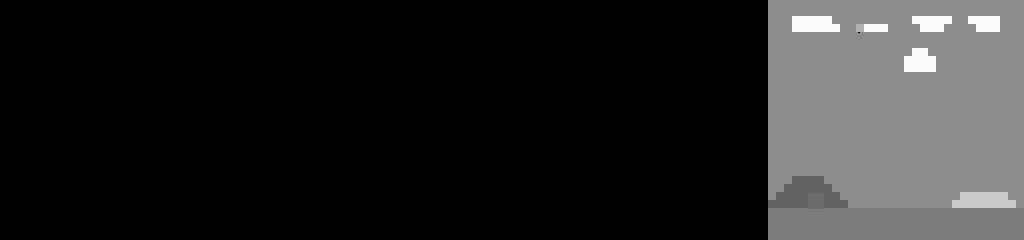

In [9]:
from PIL import Image
import numpy as np

# Get the shape of the stacked state
num_frames = 4  # We stacked 4 frames
frame_height, frame_width = state[0].shape[:2]

# Split the stacked grayscale frames into 4 separate images
frames = np.split(state[0], num_frames, axis=-1)

# Convert each frame to a valid grayscale image (remove last dimension)
frames = [np.squeeze(f, axis=-1) for f in frames]  # Remove extra channel

# Stack frames side by side
combined_frame = np.hstack(frames)  

# Display the combined image directly in Jupyter
Image.fromarray(combined_frame)



## AI MODEL ##


In [5]:
#import alldependencies
import os 
from stable_baselines3 import PPO
#for saving the models every xxx amount of steps 
from stable_baselines3.common.callbacks import BaseCallback

In [6]:
import os
from stable_baselines3.common.callbacks import BaseCallback

class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        # 🔹 Guardar el modelo cada 'check_freq' pasos
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, f'best_model_{self.n_calls}')
            self.model.save(model_path)
            print(f"🔹 Modelo guardado en: {model_path}")  

        # 🔹 Registrar la recompensa promedio en TensorBoard
        if self.locals.get("infos", None) is not None:
            episode_rewards = [info['episode']['r'] for info in self.locals["infos"] if 'episode' in info]
            if len(episode_rewards) > 0:
                mean_reward = sum(episode_rewards) / len(episode_rewards)
                self.logger.record("reward/mean_reward", mean_reward)
        
        return True  # **IMPORTANTE: Sin esto, el callback puede fallar**


In [7]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [8]:
callback = TrainAndLoggingCallback(check_freq= 10000, save_path= CHECKPOINT_DIR)


In [9]:
model = PPO('CnnPolicy', env, verbose= 1, tensorboard_log=LOG_DIR, learning_rate=0.0003, n_steps=1024)

Using cuda device
Wrapping the env in a VecTransposeImage.


In [10]:
import time

start_time = time.time()


model.learn(total_timesteps=1_000_000, callback=callback)  # Prueba con menos pasos primero
model.save("./train/final_model")  # Guardar manualmente

print("✔ Modelo final guardado en ./train/final_model")

end_time = time.time()

print(f"Tiempo de entrenamiento: {end_time - start_time} segundos")


Logging to ./logs/PPO_5


C:\Users\santi\AppData\Roaming\Python\Python38\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
C:\Users\santi\AppData\Roaming\Python\Python38\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


-----------------------------
| time/              |      |
|    fps             | 124  |
|    iterations      | 1    |
|    time_elapsed    | 8    |
|    total_timesteps | 1024 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 93          |
|    iterations           | 2           |
|    time_elapsed         | 21          |
|    total_timesteps      | 2048        |
| train/                  |             |
|    approx_kl            | 0.033462163 |
|    clip_fraction        | 0.234       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.92       |
|    explained_variance   | 0.000351    |
|    learning_rate        | 0.0003      |
|    loss                 | 3.76        |
|    n_updates            | 10          |
|    policy_gradient_loss | 0.0105      |
|    value_loss           | 43.8        |
-----------------------------------------
----------------------------------

KeyboardInterrupt: 

In [ ]:
print(env)

## TEST IT OUT

NameError: name 'gym_super_mario_bros' is not defined

In [8]:
model = PPO.load('./train/best_model_40000')
state = env.reset()

In [ ]:
state= env.reset()
while True:
    action, _ = model.predict(state)
    state, reward,done, info = env.step(action)
    env.render

C:\Users\santi\AppData\Roaming\Python\Python38\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
C:\Users\santi\AppData\Roaming\Python\Python38\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


In [ ]:
env.close()